In [4]:
library(readr)
library(dplyr)
library(lme4)

patient_gmv_demographics <- read_csv("./results/patient_gmv_demographics.csv", 
    col_types = list(MGV = col_double(), subj_id=col_character(), 
    roi=col_factor(), diagnosis=col_factor(), age=col_double(), 
    sex=col_factor(), site=col_factor()))

# Filter out sites with only 0 diagnosis
patient_gmv_demographics <- patient_gmv_demographics %>%
    group_by(site) %>%
    filter(any(diagnosis != 0)) %>%
    ungroup()

print("Bad values:")
print(sapply(patient_gmv_demographics, function(x) sum(is.na(x) | is.infinite(x))))

rois <- split(patient_gmv_demographics, patient_gmv_demographics$roi)

[1] "Bad values:"
      MGV   subj_id       roi diagnosis       age       sex      site 
        0         0         0         0         0         0         0 


In [ ]:
# NOTE: The SIR simulator gives atrophy accumulation as positive values
# Mirroring this, here we take the beta values for healthy control 
# i.e. positive beta values indicate HC GMV > SCZ GMV

# Initialize an empty list to store the beta values
beta_values <- list()

# Calculate beta values for all data
for (roi in names(rois)) {
    df <- rois[[roi]]
    model <- lmer(MGV ~ diagnosis + age + sex + (1 | site), data = df)
    beta_diagnosis <- summary(model)$coefficients["diagnosis0", "Estimate"]
    beta_values[[roi]] <- beta_diagnosis
}
# Create the initial beta_df with all data
beta_df <- data.frame(roi = names(beta_values), diagnosis_beta = as.numeric(scale(unlist(beta_values))))

# Calculate beta values for each site separately
sites <- unique(patient_gmv_demographics$site)
for (site in sites) {
    beta_values <- list()

    for (roi in names(rois)) {
        df <- rois[[roi]] %>% filter(site == !!site)
        
        model <- lm(MGV ~ diagnosis + age + sex, data = df)
        beta_diagnosis <- summary(model)$coefficients["diagnosis0", "Estimate"]
        beta_values[[roi]] <- beta_diagnosis
    }
    # Update beta_df with each site
    beta_df[[site]] <- as.numeric(scale(unlist(beta_values)))
}

# Calculate beta values after leaving each site out
for (site in sites) {
    beta_values <- list()
    
    for (roi in names(rois)) {
        df <- rois[[roi]] %>% filter(site != !!site)
        model <- lmer(MGV ~ diagnosis + age + sex + (1 | site), data = df)
        beta_diagnosis <- summary(model)$coefficients["diagnosis0", "Estimate"]
        beta_values[[roi]] <- beta_diagnosis
    }
    beta_df[[paste0("no_", site)]] <- as.numeric(scale(unlist(beta_values)))
}

print(tail(beta_df))

   roi diagnosis_beta Advan_inno BrainGluSchi Baltimore     Dallas    dallas
61  61      -2.371317 -2.5790050    -1.377178 -2.210650 -0.8421844 -2.289418
62  62      -3.593744 -3.5095077    -1.633536 -3.592556 -1.5832488 -3.447287
63  63      -1.993512 -1.3570423    -1.084366 -2.249071 -1.2940414 -1.787566
64  64      -3.215523 -3.3046333    -1.338297 -2.136595 -2.1937586 -2.675404
65  65      -1.717137 -0.7524529    -2.074192 -2.205002 -1.6811391 -2.124401
66  66      -1.747901 -0.6063370    -1.942399 -1.796295 -2.6346766 -1.528220
       boston    chicago      COBRE        HCP          A          C
61 -1.2092624 -1.6735776 -1.7250456 -2.7877115 -0.9172841 -2.2976554
62 -1.9832470 -3.1900720 -1.8993893 -3.2278961 -1.1655787 -2.9427413
63 -1.4162328 -0.9433609 -0.1376229 -1.4830127 -1.8301034 -0.7085107
64 -1.8291259 -2.0415741 -1.8856337 -2.4625731 -2.1453449 -1.9032656
65 -1.4304444 -1.6941642 -2.2222731 -1.0075198 -2.2622417 -0.9628642
66 -0.8986231 -1.6803088 -2.2773613 -0.5202181 

In [ ]:
write.csv(beta_df, "./results/betas.csv", row.names = FALSE)
# write.table(beta_df$diagnosis_beta, "betas_diag.csv", col.names = FALSE, row.names = FALSE, sep = ",")

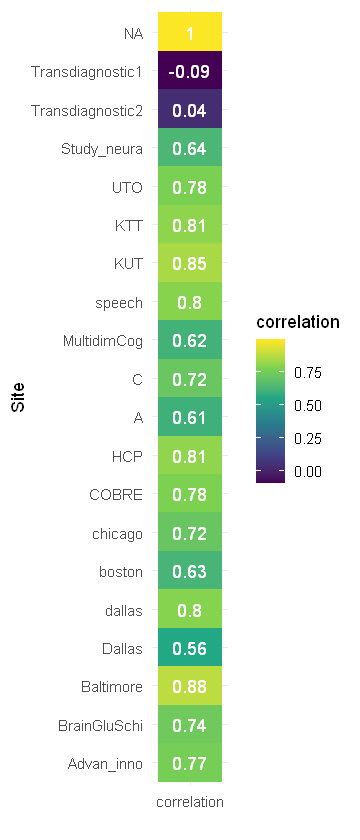

In [ ]:
# visualise between-site correlations
correlations <- sapply(beta_df[-1], function(x) cor(beta_df$diagnosis_beta, x, use = "complete.obs"))
correlation_df <- data.frame(site = names(correlations), correlation = correlations)

library(ggplot2)

# Reorder the site factor to match the original order of sites
correlation_df$site <- factor(correlation_df$site, levels = unique(patient_gmv_demographics$site))
options(repr.plot.width = 3)
# Create the heatmap with flipped axes
ggplot(correlation_df, aes(y = site, x = "correlation", fill = correlation)) +
    geom_tile() +
    geom_text(aes(label = round(correlation, 2)), color = "white") +
    scale_fill_viridis_c() +
    theme_minimal() +
    labs(y = "Site", x = "")
